<a href="https://colab.research.google.com/github/san9roy/CubeSat-Simulation/blob/main/CUBESAT_SIMULATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

In [4]:
# ============================================================
# Constants / utilities
# ============================================================
MU_EARTH = 3.986004418e14      # [m^3/s^2]
R_EARTH = 6378137.0            # [m]

def norm(v):
    return np.linalg.norm(v)

In [5]:
# ============================================================
# Quaternion math (scalar-last: q = [qx,qy,qz,qw])
# ============================================================
def q_normalize(q):
    return q / np.linalg.norm(q)

def q_conj(q):
    return np.array([-q[0], -q[1], -q[2], q[3]])

def q_mul(q1, q2):
    """Hamilton product, scalar-last."""
    x1, y1, z1, w1 = q1
    x2, y2, z2, w2 = q2
    x = w1*x2 + x1*w2 + y1*z2 - z1*y2
    y = w1*y2 - x1*z2 + y1*w2 + z1*x2
    z = w1*z2 + x1*y2 - y1*x2 + z1*w2
    w = w1*w2 - x1*x2 - y1*y2 - z1*z2
    return np.array([x, y, z, w])

def quat_error(q_current, q_ref):
    """
    Quaternion error that rotates current -> ref:
      q_err = q_ref * conj(q_current)
    """
    q_err = q_mul(q_ref, q_conj(q_current))
    if q_err[3] < 0:  # shortest rotation
        q_err = -q_err
    return q_err

In [6]:
# ============================================================
# Keplerian <-> Cartesian
# ============================================================
def kepler_to_rv(a, e, i, raan, argp, nu, mu=MU_EARTH):
    """
    Classical orbital elements -> ECI r,v.
    a [m], e [-], i/raan/argp/nu [rad]
    """
    p = a * (1 - e**2)
    r_pf = np.array([
        p * np.cos(nu) / (1 + e*np.cos(nu)),
        p * np.sin(nu) / (1 + e*np.cos(nu)),
        0.0
    ])
    v_pf = np.array([
        -np.sqrt(mu/p) * np.sin(nu),
        np.sqrt(mu/p) * (e + np.cos(nu)),
        0.0
    ])

    cr, sr = np.cos(raan), np.sin(raan)
    ci, si = np.cos(i), np.sin(i)
    cw, sw = np.cos(argp), np.sin(argp)

    R3_raan = np.array([[cr, -sr, 0],[sr, cr, 0],[0,0,1]])
    R1_i    = np.array([[1,0,0],[0,ci,-si],[0,si,ci]])
    R3_argp = np.array([[cw, -sw, 0],[sw, cw, 0],[0,0,1]])

    Q = R3_raan @ R1_i @ R3_argp
    r_eci = Q @ r_pf
    v_eci = Q @ v_pf
    return r_eci, v_eci

def rv_to_kepler(r, v, mu=MU_EARTH):
    """ECI r,v -> (a,e,i,raan,argp,nu)."""
    rmag = norm(r)
    vmag = norm(v)

    h = np.cross(r, v)
    hmag = norm(h)

    i = np.arccos(np.clip(h[2] / hmag, -1.0, 1.0))

    n = np.cross(np.array([0,0,1.0]), h)
    nmag = norm(n)

    e_vec = (1/mu) * ((vmag**2 - mu/rmag)*r - np.dot(r, v)*v)
    e = norm(e_vec)

    if nmag < 1e-12:
        raan = 0.0
    else:
        raan = np.arctan2(n[1], n[0]) % (2*np.pi)

    if nmag < 1e-12 or e < 1e-12:
        argp = 0.0
    else:
        argp = np.arctan2(np.dot(np.cross(n, e_vec), h)/hmag, np.dot(n, e_vec)) % (2*np.pi)

    if e < 1e-12:
        nu = np.arctan2(np.dot(np.cross(n, r), h)/hmag, np.dot(n, r)) % (2*np.pi)
    else:
        nu = np.arctan2(np.dot(np.cross(e_vec, r), h)/hmag, np.dot(e_vec, r)) % (2*np.pi)

    energy = 0.5*vmag**2 - mu/rmag
    a = -mu / (2*energy)
    return a, e, i, raan, argp, nu

In [7]:
# ============================================================
# Orbit dynamics: two-body + optional drag
# ============================================================
def atmospheric_density_exponential(h):
    """
    Very rough exponential atmosphere model.
    h: altitude above Earth [m]
    rho: [kg/m^3]
    """
    h0 = 400e3
    rho0 = 3e-12    # tune this higher to see stronger decay
    H = 60e3
    return rho0 * np.exp(-(h - h0)/H)

def accel_two_body(r, mu=MU_EARTH):
    rmag = norm(r)
    return -mu * r / (rmag**3)

def accel_drag(r, v, Cd=2.2, A=0.01, m=3.0):
    """
    Simple drag in inertial frame ignoring winds / Earth rotation:
      a_d = -1/2 * rho * Cd*A/m * |v| * v
    """
    h = norm(r) - R_EARTH
    if h < 0:
        return np.zeros(3)
    rho = atmospheric_density_exponential(h)
    vmag = norm(v)
    if vmag < 1e-9:
        return np.zeros(3)
    return -0.5 * rho * Cd * A / m * vmag * v

def rk4_step_orbit(r, v, dt, use_drag=False, sat_params=None):
    if sat_params is None:
        sat_params = dict(Cd=2.2, A=0.01, m=3.0)

    def f(state):
        rr = state[:3]
        vv = state[3:]
        a = accel_two_body(rr)
        if use_drag:
            a = a + accel_drag(rr, vv, **sat_params)
        return np.hstack([vv, a])

    y0 = np.hstack([r, v])
    k1 = f(y0)
    k2 = f(y0 + 0.5*dt*k1)
    k3 = f(y0 + 0.5*dt*k2)
    k4 = f(y0 + dt*k3)
    y1 = y0 + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
    return y1[:3], y1[3:]

In [8]:
# ============================================================
# Attitude: reference, dynamics, control
# ============================================================
def nadir_reference_quaternion(r_eci, v_eci):
    """
    Nadir-pointing reference:
    - body +Z points toward Earth center: z = -r_hat
    - body +X approximately along velocity, orthogonal to z
    Returns q_ref (body->inertial), scalar-last.
    """
    rhat = r_eci / norm(r_eci)
    z_b = -rhat
    vhat = v_eci / norm(v_eci)

    x_temp = vhat - z_b * np.dot(vhat, z_b)
    if norm(x_temp) < 1e-9:
        x_temp = np.array([1.0, 0.0, 0.0])
    x_b = x_temp / norm(x_temp)
    y_b = np.cross(z_b, x_b)

    R = np.column_stack([x_b, y_b, z_b])  # columns = body axes in inertial

    tr = np.trace(R)
    if tr > 0:
        S = np.sqrt(tr + 1.0) * 2
        qw = 0.25 * S
        qx = (R[2,1] - R[1,2]) / S
        qy = (R[0,2] - R[2,0]) / S
        qz = (R[1,0] - R[0,1]) / S
    else:
        if (R[0,0] > R[1,1]) and (R[0,0] > R[2,2]):
            S = np.sqrt(1.0 + R[0,0] - R[1,1] - R[2,2]) * 2
            qw = (R[2,1] - R[1,2]) / S
            qx = 0.25 * S
            qy = (R[0,1] + R[1,0]) / S
            qz = (R[0,2] + R[2,0]) / S
        elif R[1,1] > R[2,2]:
            S = np.sqrt(1.0 + R[1,1] - R[0,0] - R[2,2]) * 2
            qw = (R[0,2] - R[2,0]) / S
            qx = (R[0,1] + R[1,0]) / S
            qy = 0.25 * S
            qz = (R[1,2] + R[2,1]) / S
        else:
            S = np.sqrt(1.0 + R[2,2] - R[0,0] - R[1,1]) * 2
            qw = (R[1,0] - R[0,1]) / S
            qx = (R[0,2] + R[2,0]) / S
            qy = (R[1,2] + R[2,1]) / S
            qz = 0.25 * S

    return q_normalize(np.array([qx, qy, qz, qw]))

def pd_attitude_controller(q, w, q_ref, Kp=0.08, Kd=0.35, torque_max=3e-3):
    """
    PD using quaternion error.
    Small-angle proxy: angle_err ~ 2*q_err_vec
    """
    q_err = quat_error(q, q_ref)
    angle_err = 2.0 * q_err[:3]
    w_err = w  # w_ref assumed 0 in body frame for simplicity

    tau = -Kp * angle_err - Kd * w_err

    tnorm = norm(tau)
    if tnorm > torque_max:
        tau = tau * (torque_max / tnorm)
    return tau

def rk4_step_attitude(q, w, dt, J, torque_func):
    """
    q: quaternion (body->inertial), scalar-last
    w: angular rate in body frame [rad/s]
    J: inertia matrix [kg*m^2]
    torque_func(q,w): torque in body [N*m]
    """
    Jinv = np.linalg.inv(J)

    def q_dot(qi, wi):
        wx, wy, wz = wi
        Omega = np.array([
            [0,   wz, -wy, wx],
            [-wz, 0,   wx, wy],
            [wy, -wx, 0,   wz],
            [-wx,-wy,-wz,  0],
        ])
        return 0.5 * Omega @ qi

    def w_dot(qi, wi):
        tau = torque_func(qi, wi)
        return Jinv @ (tau - np.cross(wi, J @ wi))

    y0 = np.hstack([q, w])

    def f(y):
        qi = y[:4]
        wi = y[4:]
        return np.hstack([q_dot(qi, wi), w_dot(qi, wi)])

    k1 = f(y0)
    k2 = f(y0 + 0.5*dt*k1)
    k3 = f(y0 + 0.5*dt*k2)
    k4 = f(y0 + dt*k3)

    y1 = y0 + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
    q1 = q_normalize(y1[:4])
    w1 = y1[4:]
    return q1, w1

def attitude_error_angle_deg(q, q_ref):
    q_err = quat_error(q, q_ref)
    qw = np.clip(q_err[3], -1.0, 1.0)
    angle = 2.0 * np.arccos(qw)
    if angle > np.pi:
        angle = 2*np.pi - angle
    return np.rad2deg(angle)


In [9]:
# ============================================================
# Sensor models
# ============================================================
class GyroModel:
    """
    Rate gyro: w_meas = w_true + bias + noise
    bias evolves as random walk.
    """
    def __init__(self, bias0=np.zeros(3), sigma_noise=0.001, sigma_bias_rw=1e-5, rng=None):
        self.bias = bias0.astype(float)
        self.sigma_noise = sigma_noise
        self.sigma_bias_rw = sigma_bias_rw
        self.rng = np.random.default_rng() if rng is None else rng

    def step(self, w_true, dt):
        self.bias += self.sigma_bias_rw * np.sqrt(dt) * self.rng.standard_normal(3)
        noise = self.sigma_noise * self.rng.standard_normal(3)
        return w_true + self.bias + noise

class GPSPositionModel:
    def __init__(self, sigma_pos=8.0, rng=None):
        self.sigma_pos = sigma_pos
        self.rng = np.random.default_rng() if rng is None else rng

    def measure(self, r_true):
        return r_true + self.sigma_pos * self.rng.standard_normal(3)

In [10]:
# ============================================================
# Simulation
# ============================================================
def run_sim(
    t_final=2*3600.0,
    dt=1.0,
    use_drag=False,
    seed=2
):
    rng = np.random.default_rng(seed)

    # Orbit init from Kepler (example)
    a = R_EARTH + 500e3
    e = 0.001
    inc = np.deg2rad(51.6)
    raan = np.deg2rad(40.0)
    argp = np.deg2rad(0.0)
    nu = np.deg2rad(0.0)
    r, v = kepler_to_rv(a, e, inc, raan, argp, nu)

    # Attitude init
    q = q_normalize(np.array([0.0, 0.0, 0.0, 1.0]))
    w = np.deg2rad(np.array([0.1, -0.05, 0.08]))

    # CubeSat-ish inertia
    J = np.diag([0.02, 0.018, 0.015])

    # Drag parameters (tune A/m for stronger decay)
    sat_params = dict(Cd=2.2, A=0.01, m=3.0)

    # Sensors
    gyro = GyroModel(
        bias0=np.deg2rad(np.array([0.02, -0.015, 0.01])),
        sigma_noise=np.deg2rad(0.005),
        sigma_bias_rw=np.deg2rad(0.0002),
        rng=rng
    )
    gps = GPSPositionModel(sigma_pos=8.0, rng=rng)

    N = int(np.floor(t_final/dt)) + 1
    t_hist = np.zeros(N)

    r_hist = np.zeros((N,3))
    v_hist = np.zeros((N,3))

    q_hist = np.zeros((N,4))
    w_hist = np.zeros((N,3))

    r_gps_hist = np.zeros((N,3))
    w_gyro_hist = np.zeros((N,3))

    pos_err_hist = np.zeros(N)

    # Controller gains
    Kp, Kd = 0.08, 0.35
    torque_max = 3e-3

    for k in range(N):
        t = k*dt
        t_hist[k] = t

        # log truth
        r_hist[k] = r
        v_hist[k] = v
        q_hist[k] = q
        w_hist[k] = w

        # noisy sensors
        r_gps = gps.measure(r)
        w_meas = gyro.step(w, dt)
        r_gps_hist[k] = r_gps
        w_gyro_hist[k] = w_meas

        # position measurement error magnitude
        pos_err_hist[k] = norm(r_gps - r)

        # reference attitude (nadir)
        q_ref = nadir_reference_quaternion(r, v)

        def torque_func(qi, wi):
            return pd_attitude_controller(qi, wi, q_ref, Kp=Kp, Kd=Kd, torque_max=torque_max)

        # step forward
        if k < N-1:
            r, v = rk4_step_orbit(r, v, dt, use_drag=use_drag, sat_params=sat_params)
            q, w = rk4_step_attitude(q, w, dt, J, torque_func)

    # summary
    pos_rmse = np.sqrt(np.mean(pos_err_hist**2))
    pos_mean = np.mean(pos_err_hist)
    pos_p95  = np.quantile(pos_err_hist, 0.95)

    a0, e0, i0, *_ = rv_to_kepler(r_hist[0], v_hist[0])
    a1, e1, i1, *_ = rv_to_kepler(r_hist[-1], v_hist[-1])

    summary = {
        "pos_err_mean_m": float(pos_mean),
        "pos_err_rmse_m": float(pos_rmse),
        "pos_err_p95_m": float(pos_p95),
        "a_start_m": float(a0),
        "a_end_m": float(a1),
        "e_start": float(e0),
        "e_end": float(e1),
        "i_start_deg": float(np.rad2deg(i0)),
        "i_end_deg": float(np.rad2deg(i1)),
    }

    return {
        "t": t_hist,
        "r": r_hist, "v": v_hist,
        "q": q_hist, "w": w_hist,
        "r_gps": r_gps_hist,
        "w_gyro": w_gyro_hist,
        "pos_err": pos_err_hist,
        "summary": summary
    }

In [11]:
# ============================================================
# Metrics + plotting
# ============================================================
def compute_timeseries_metrics(res):
    t = res["t"]
    r = res["r"]
    v = res["v"]
    q = res["q"]
    w = res["w"]
    pos_err = res["pos_err"]

    altitude = np.linalg.norm(r, axis=1) - R_EARTH

    a_hist = np.zeros_like(t)
    att_err_deg = np.zeros_like(t)

    for k in range(len(t)):
        a_k, *_ = rv_to_kepler(r[k], v[k])
        a_hist[k] = a_k

        q_ref = nadir_reference_quaternion(r[k], v[k])
        att_err_deg[k] = attitude_error_angle_deg(q[k], q_ref)

    return altitude, a_hist, att_err_deg, w, pos_err

def plot_3d_orbit(r, title):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.plot(r[:,0], r[:,1], r[:,2])
    ax.set_title(title)
    ax.set_xlabel("x [m]")
    ax.set_ylabel("y [m]")
    ax.set_zlabel("z [m]")
    ax.set_box_aspect([1,1,1])
    plt.tight_layout()

def plot_altitude_vs_time(t, altitude, title):
    plt.figure()
    plt.plot(t/60.0, altitude/1000.0)
    plt.title(title)
    plt.xlabel("Time [min]")
    plt.ylabel("Altitude [km]")
    plt.tight_layout()

def plot_semimajor_axis_vs_time(t, a_hist, title):
    plt.figure()
    plt.plot(t/60.0, a_hist/1000.0)
    plt.title(title)
    plt.xlabel("Time [min]")
    plt.ylabel("Semi-major axis a [km]")
    plt.tight_layout()

def plot_attitude_error_vs_time(t, att_err_deg, title):
    plt.figure()
    plt.plot(t/60.0, att_err_deg)
    plt.title(title)
    plt.xlabel("Time [min]")
    plt.ylabel("Attitude error [deg]")
    plt.tight_layout()

def plot_angular_rate_vs_time(t, w_body, title):
    plt.figure()
    plt.plot(t/60.0, np.rad2deg(w_body[:,0]), label="wx")
    plt.plot(t/60.0, np.rad2deg(w_body[:,1]), label="wy")
    plt.plot(t/60.0, np.rad2deg(w_body[:,2]), label="wz")
    plt.title(title)
    plt.xlabel("Time [min]")
    plt.ylabel("Angular rate [deg/s]")
    plt.legend()
    plt.tight_layout()

def plot_position_error_hist(pos_err, title):
    plt.figure()
    plt.hist(pos_err, bins=40)
    plt.title(title)
    plt.xlabel("Position error ||r_gps - r_truth|| [m]")
    plt.ylabel("Count")
    plt.tight_layout()

def plot_all(res, prefix):
    altitude, a_hist, att_err_deg, w_body, pos_err = compute_timeseries_metrics(res)
    t = res["t"]
    r = res["r"]

    plot_3d_orbit(r, f"3D Orbit Trajectory {prefix}")
    plot_altitude_vs_time(t, altitude, f"Altitude vs Time {prefix}")
    plot_semimajor_axis_vs_time(t, a_hist, f"Semi-major Axis vs Time {prefix}")
    plot_attitude_error_vs_time(t, att_err_deg, f"Attitude Error vs Time {prefix}")
    plot_angular_rate_vs_time(t, w_body, f"Angular Rate vs Time {prefix}")
    plot_position_error_hist(pos_err, f"Position Error Histogram {prefix}")

---- Simulation summary (NO DRAG) ----
pos_err_mean_m: 12.790615848849407
pos_err_rmse_m: 13.868319896840484
pos_err_p95_m: 22.200518642930856
a_start_m: 6878137.0
a_end_m: 6878136.999999974
e_start: 0.000999999999999901
e_end: 0.0009999999999774712
i_start_deg: 51.60000000000001
i_end_deg: 51.59999999999992

---- Simulation summary (DRAG) ----
pos_err_mean_m: 12.786991377153267
pos_err_rmse_m: 13.876224724708743
pos_err_p95_m: 22.365309673544754
a_start_m: 6878137.0
a_end_m: 6878132.306288876
e_start: 0.000999999999999901
e_end: 0.0009999879939998407
i_start_deg: 51.60000000000001
i_end_deg: 51.60000000000044


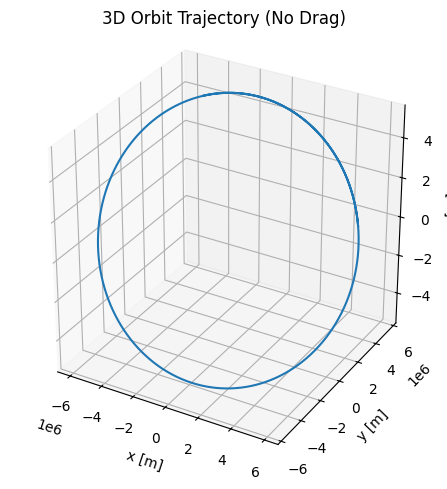

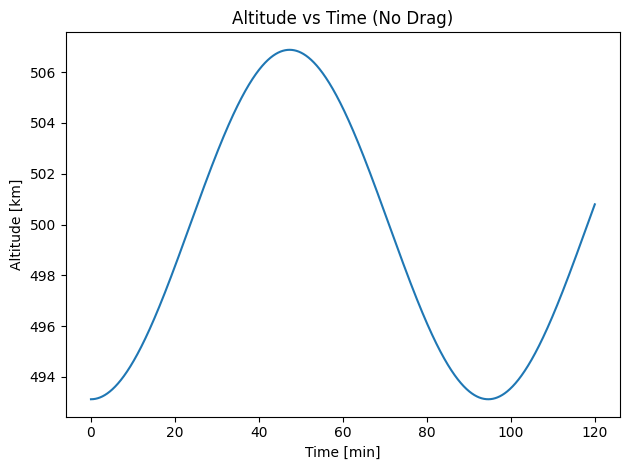

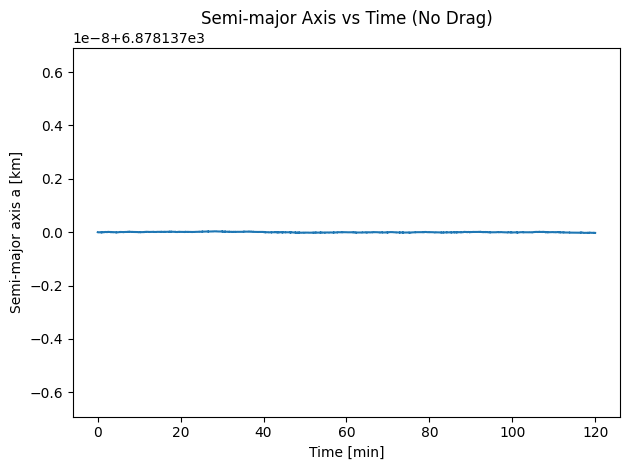

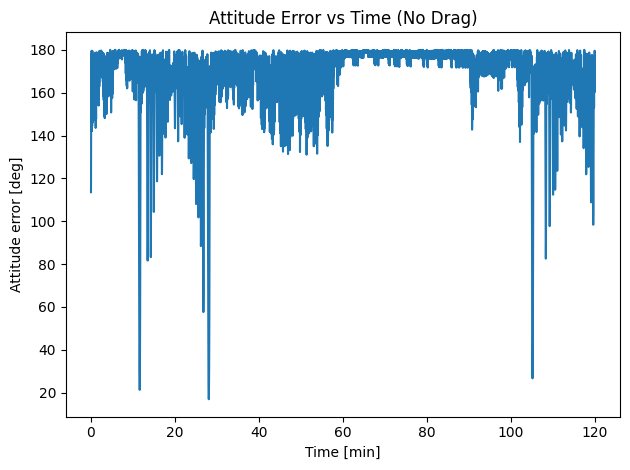

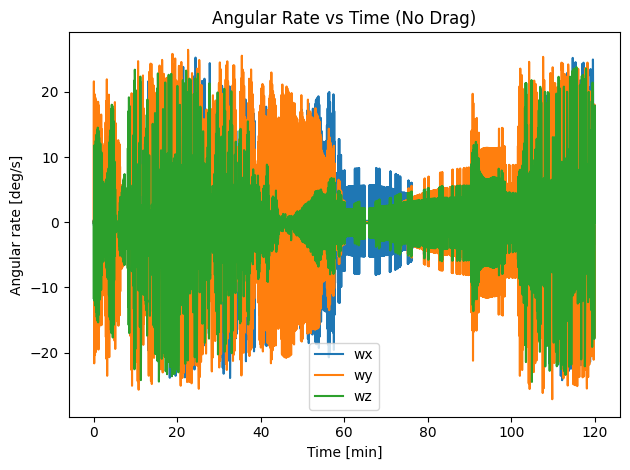

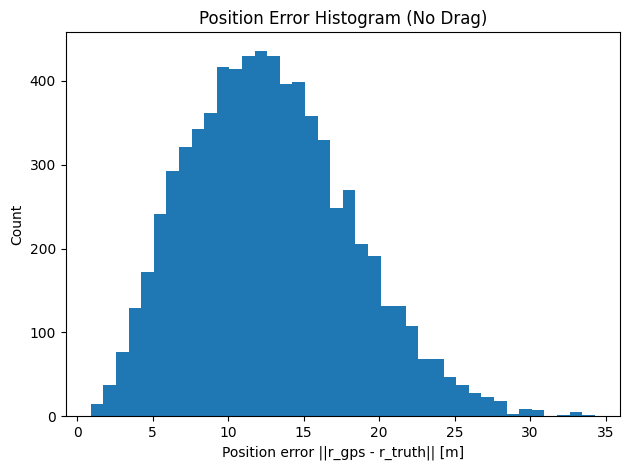

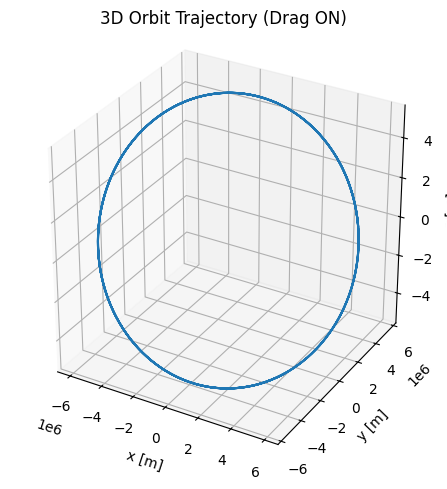

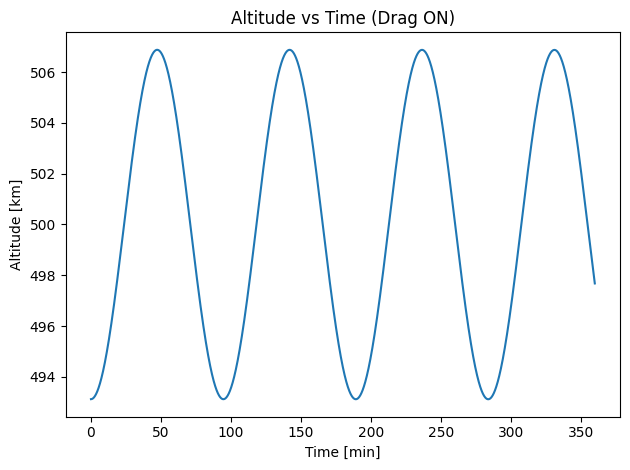

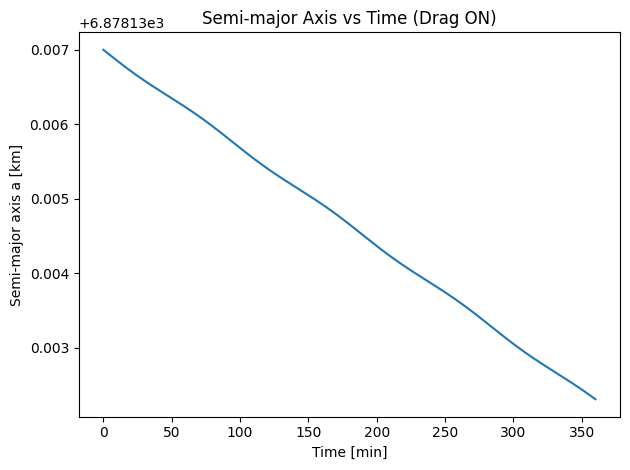

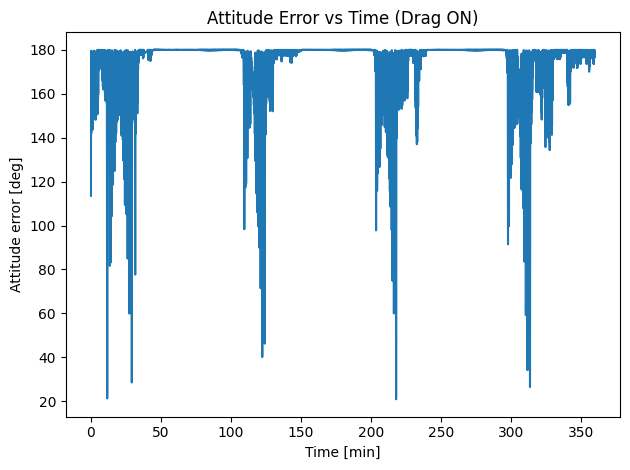

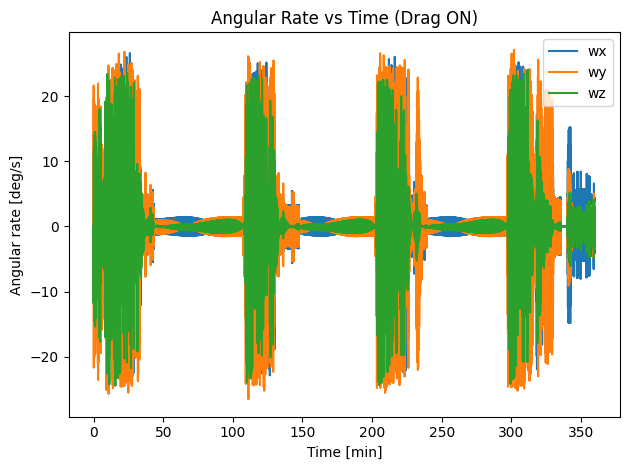

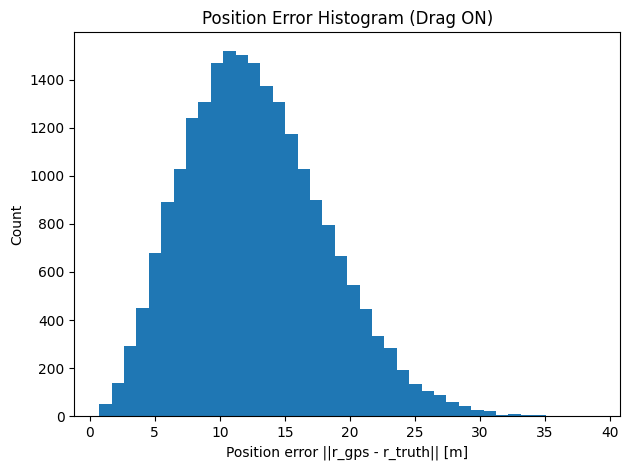

In [12]:
# ============================================================
# Main
# ============================================================
if __name__ == "__main__":
    # Baseline (no drag)
    res_no_drag = run_sim(t_final=2*3600, dt=1.0, use_drag=False, seed=2)
    print("---- Simulation summary (NO DRAG) ----")
    for k, v in res_no_drag["summary"].items():
        print(f"{k}: {v}")

    # Drag case: longer so decay is easier to see
    res_drag = run_sim(t_final=6*3600, dt=1.0, use_drag=True, seed=2)
    print("\n---- Simulation summary (DRAG) ----")
    for k, v in res_drag["summary"].items():
        print(f"{k}: {v}")

    # Plots
    plot_all(res_no_drag, "(No Drag)")
    plot_all(res_drag, "(Drag ON)")

    plt.show()
